## Split data

In [1]:
import os
import utils

path2data = "data"
sub_folder_jpg = "micro_jpg_crop"
path2ajpgs = os.path.join(path2data, sub_folder_jpg)

In [3]:
all_vids, all_labels, catgs = utils.get_vids(path2ajpgs) 
len(all_vids), len(all_labels), len(catgs)

(2399, 2399, 2)

In [4]:
all_vids[:1], all_labels[:3], catgs[:5]

(['data\\micro_jpg_crop\\stalled\\100109'],
 ['stalled', 'stalled', 'stalled'],
 ['stalled', 'unstalled'])

In [5]:
labels_dict = {}
ind = 0
catgs.sort(reverse=True) 
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1
labels_dict # {'unstalled': 0, 'stalled': 1}

{'unstalled': 0, 'stalled': 1}

In [6]:
num_classes = len(catgs)
unique_ids = [id_ for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
len(unique_ids),len(unique_labels)

(2399, 2399)

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]
print(len(train_ids), len(train_labels)) 

test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]
print(len(test_ids), len(test_labels))

2159 2159
240 240


In [8]:
train_ids[:5], train_labels[:5]

(['data\\micro_jpg_crop\\stalled\\575515',
  'data\\micro_jpg_crop\\stalled\\370799',
  'data\\micro_jpg_crop\\unstalled\\458711',
  'data\\micro_jpg_crop\\stalled\\103390',
  'data\\micro_jpg_crop\\stalled\\377142'],
 ['stalled', 'stalled', 'unstalled', 'stalled', 'stalled'])

## Define dataset

In [9]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):      
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs = glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)
        
        seed = np.random.randint(1e9)        
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [10]:
# choose one
model_type = "3dcnn"
# model_type = "rnn"    

timesteps =16
if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [11]:
import torchvision.transforms as transforms

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),  
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),    
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

In [12]:
train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print(len(train_ds))

imgs, label = train_ds[10]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

2159


(torch.Size([16, 3, 112, 112]), 0, tensor(-1.8952), tensor(2.8736))

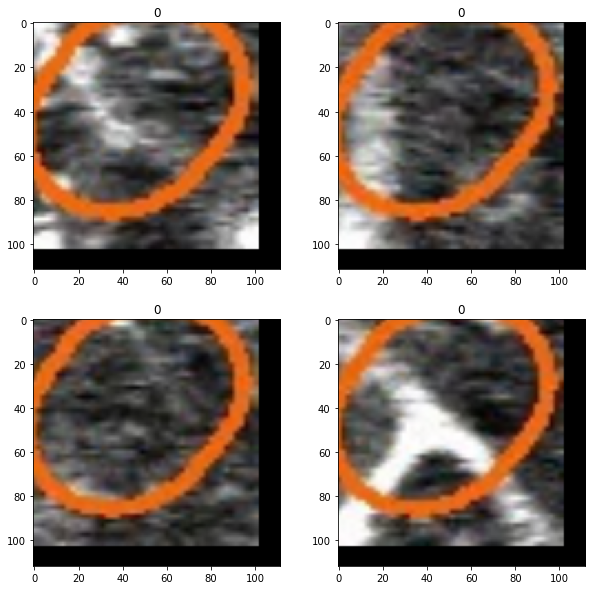

In [13]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(utils.denormalize(img, mean, std))
    plt.title(label)

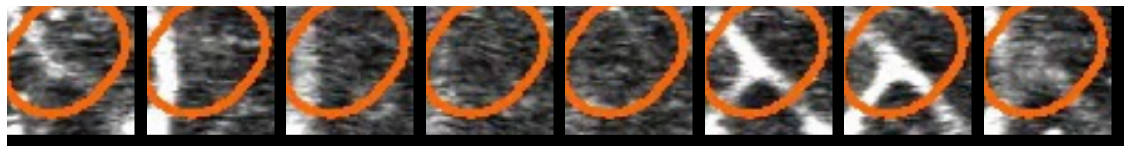

In [14]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for ii,img in enumerate(imgs[::2]):
    plt.subplot(1,8,ii+1)
    plt.imshow(utils.denormalize(img, mean, std))
    plt.axis("off")

In [15]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ]) 
test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
print(len(test_ds))

imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

240


(torch.Size([16, 3, 112, 112]), 0, tensor(-1.8952), tensor(2.8736))

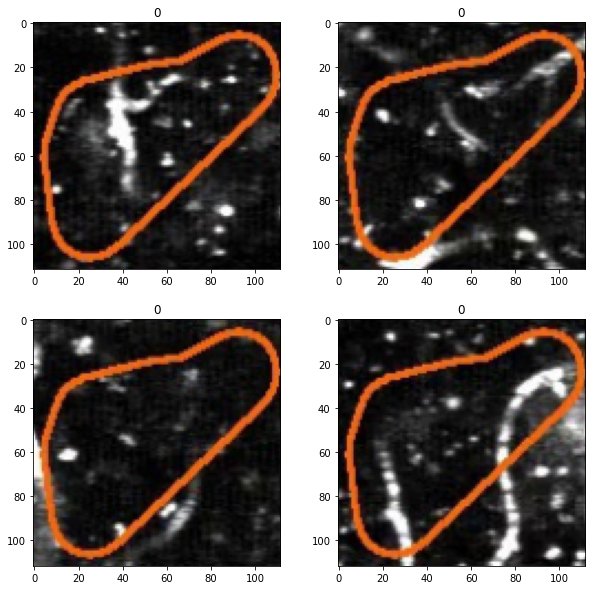

In [16]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(utils.denormalize(img, mean, std))
    plt.title(label)

## Define data loaders

In [17]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor
    

batch_size = 16 
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= batch_size, #2*batch_size
                         shuffle=False, collate_fn= collate_fn_rnn)  
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size, 
                          shuffle=True, collate_fn= collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size= batch_size, #2*batch_size
                         shuffle=False, collate_fn= collate_fn_r3d_18)

In [17]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([16, 3, 16, 112, 112]) torch.Size([16])


In [18]:
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([16, 3, 16, 112, 112]) torch.Size([16])


## Define Model

In [19]:
from torchvision import models
from torch import nn

if model_type == "rnn":
    params_model={
        "num_classes": num_classes,
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}
    model = utils.Resnt18Rnn(params_model)        
else:
    model = models.video.r3d_18(pretrained=True, progress=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

In [20]:
with torch.no_grad():
    if model_type=="rnn":
        x = torch.zeros(1, 16, 3, h, w)
    else:
        x = torch.zeros(1, 3, 16, h, w)
    y= model(x)
    print(y.shape)

torch.Size([1, 2])


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [21]:
path2weights = "./models/weights.pt"
torch.save(model.state_dict(), path2weights)

## Train Model

In [22]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
os.makedirs("./models", exist_ok=True)

params_train={
    "num_epochs": 2000,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": "./models/weights_"+model_type+".pt",
    }
model, loss_hist, metric_hist = utils.train_val(model,params_train)

cy: 5.83
----------
Epoch 1820/1999, current lr=1.46484375e-08
train loss: 0.004240, dev loss: 0.030358, accuracy: 5.83
----------
Epoch 1821/1999, current lr=1.46484375e-08
train loss: 0.006101, dev loss: 0.030588, accuracy: 5.83
----------
Epoch 1822/1999, current lr=1.46484375e-08
train loss: 0.005197, dev loss: 0.030197, accuracy: 5.83
----------
Epoch 1823/1999, current lr=1.46484375e-08
train loss: 0.005220, dev loss: 0.029734, accuracy: 5.83
----------
Epoch 1824/1999, current lr=1.46484375e-08
train loss: 0.004152, dev loss: 0.029789, accuracy: 5.83
----------
Epoch 1825/1999, current lr=1.46484375e-08
train loss: 0.003264, dev loss: 0.030020, accuracy: 5.83
----------
Epoch 1826/1999, current lr=1.46484375e-08
train loss: 0.004797, dev loss: 0.030300, accuracy: 5.83
----------
Epoch 1827/1999, current lr=1.46484375e-08
train loss: 0.004971, dev loss: 0.030431, accuracy: 5.83
----------
Epoch 1828/1999, current lr=1.46484375e-08
train loss: 0.003806, dev loss: 0.030243, accurac

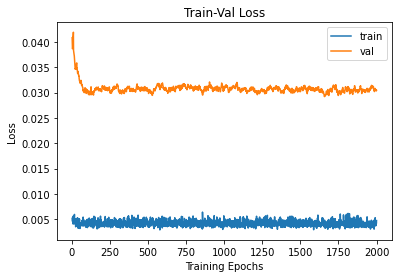

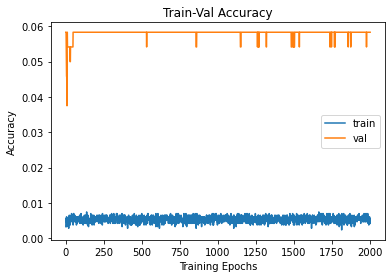

In [23]:
utils.plot_loss(loss_hist, metric_hist)

In [31]:
import shutil
def save_ckp(state, is_best, checkpoint_dir, best_model_dir):
    f_path = checkpoint_dir
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_dir
        shutil.copyfile(f_path, best_fpath)

In [33]:
epoch = 1999
checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': opt.state_dict()
}

is_best = True
checkpoint_dir = 'models/checkpoint_2000.pt'
model_dir = 'models/best_model.pt'
save_ckp(checkpoint, is_best, checkpoint_dir, model_dir)

In [22]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [27]:
optimizer = optim.Adam(model.parameters(), lr=3e-5)
ckp_path = "models/checkpoint_2000.pt"
model, optimizer, start_epoch = load_ckp(ckp_path, model, optimizer)

In [28]:
params_train={
    "num_epochs": 8000,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": "./models/weights_"+model_type+".pt",
    }
model, loss_hist, metric_hist = utils.train_val(model,params_train)

cy: 5.83
----------
Epoch 7820/7999, current lr=1.46484375e-08
train loss: 0.003364, dev loss: 0.027666, accuracy: 5.83
----------
Epoch 7821/7999, current lr=1.46484375e-08
train loss: 0.004097, dev loss: 0.027284, accuracy: 5.83
----------
Epoch 7822/7999, current lr=1.46484375e-08
train loss: 0.003124, dev loss: 0.027403, accuracy: 5.83
----------
Epoch 7823/7999, current lr=1.46484375e-08
train loss: 0.003609, dev loss: 0.027415, accuracy: 5.83
----------
Epoch 7824/7999, current lr=1.46484375e-08
train loss: 0.004429, dev loss: 0.027705, accuracy: 5.83
----------
Epoch 7825/7999, current lr=1.46484375e-08
train loss: 0.003687, dev loss: 0.027309, accuracy: 5.83
----------
Epoch 7826/7999, current lr=1.46484375e-08
train loss: 0.003944, dev loss: 0.027429, accuracy: 5.83
----------
Epoch 7827/7999, current lr=1.46484375e-08
train loss: 0.005093, dev loss: 0.027125, accuracy: 5.83
----------
Epoch 7828/7999, current lr=1.46484375e-08
train loss: 0.003906, dev loss: 0.027069, accurac

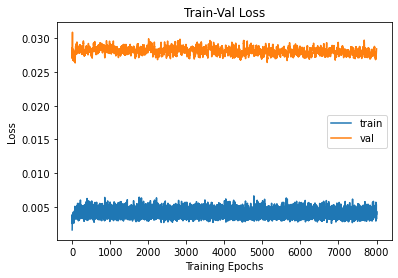

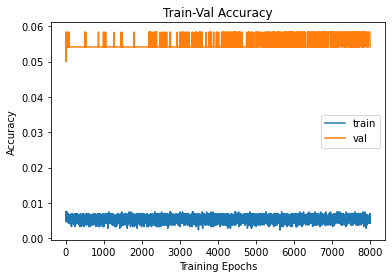

In [33]:
utils.plot_loss(loss_hist, metric_hist)

In [32]:
epoch = 7999
checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': opt.state_dict()
}
is_best = True
checkpoint_dir = 'models/checkpoint_10000.pt'
model_dir = 'models/best_model.pt'
save_ckp(checkpoint, is_best, checkpoint_dir, model_dir)